In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load Data

In [14]:
image_transforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

In [15]:
dataset_path="./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [16]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [17]:
num_classes=len(dataset.classes)
num_classes

6

In [18]:
##These images are big and we know that when we build a neural network, we will have to resize them to a smaller size for efficient processing. so in before steps while loading data we are doing the required transformations

In [19]:
train_size=int(0.75*len(dataset))
val_size=len(dataset)-train_size    
train_size,val_size

(1725, 575)

In [20]:
from torch.utils.data import random_split   

train_dataset, val_dataset = random_split(dataset,[train_size,val_size])

In [21]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=32,shuffle=False)

In [22]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [23]:
images[0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -1.8782, -1.8953, -2.0665],
         [-2.0152, -2.0152, -1.9295,  ..., -1.8782, -1.8953, -2.0665],
         [-1.6213, -1.6213, -1.6042,  ..., -1.8782, -1.8953, -2.0665],
         ...,
         [-1.5870, -0.0116,  0.1426,  ...,  0.3138,  0.1597,  0.1426],
         [-1.5699,  0.0227,  0.1426,  ..., -1.1932, -1.6213, -1.6727],
         [-1.5528,  0.0569,  0.1768,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -1.8081, -1.8256, -1.9832],
         [-1.9307, -1.9307, -1.8431,  ..., -1.8081, -1.8256, -1.9832],
         [-1.5280, -1.5280, -1.5105,  ..., -1.8081, -1.8256, -1.9832],
         ...,
         [-1.4755,  0.1877,  0.3277,  ...,  0.5728,  0.4153,  0.3978],
         [-1.4580,  0.2052,  0.3277,  ..., -1.0378, -1.5105, -1.5630],
         [-1.4405,  0.2577,  0.3803,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.5256, -1.5430, -1.7347],
         [-1.6999, -1.6824, -1.5953,  ..., -1

In [24]:
images[0].shape


torch.Size([3, 224, 224])

In [26]:
labels[0] ##2 implies F_normal

tensor(2)

In [27]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3785625].


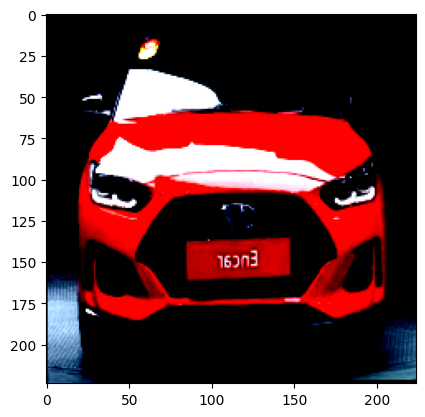

In [28]:
#plt.imshow(images[0])##imshow requires dimensions first and channels at last we use permute to change the dimensions

plt.imshow(images[0].permute(1,2,0))

In [ ]:
labels[4]##rear_breakage

tensor(3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6988237].


Text(0.5, 1.0, 'tensor(3)')

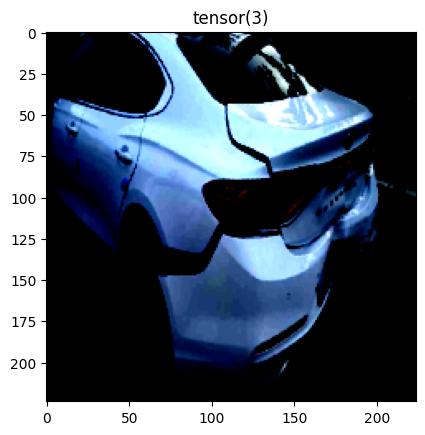

In [32]:
plt.imshow(images[4].permute(1,2,0))
plt.title(labels[4])

### Model-1:Training with CNN

In [34]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),##input is 3*224*224 output is 16*224*224
            nn.ReLU(),##activation function output is 16*224*224
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),##output is 16*112*112
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),##output is 32*112*112
            nn.ReLU(),##activation function output is 32*112*112
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),##output is 32*56*56
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),##output is 64*56*56
            nn.ReLU(),##activation function output is 64*56*56
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),##output is 64*28*28
            nn.Flatten(),##output is 64*28*28=50176
            nn.Linear(in_features=64*28*28,out_features=512),
            nn.ReLU(),##activation function output is 512
            nn.Linear(in_features=512,out_features=num_classes)
        )
    
    def forward(self,x):
        x=self.network(x)
        return x

In [35]:
model=CarClassifierCNN(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)  

In [48]:
def train_model(model,criterion,optimizer,epochs=5):
    start=time.time()
    for epoch in range(epochs):
        running_loss=0.0
        for batch_num,(images,labels) in enumerate(train_loader):
            images,labels=images.to(device),labels.to(device)

            ##Zero the gradient parameters
            optimizer.zero_grad()
            
            ##Forward Pass
            outputs=model(images)
            loss=criterion(outputs,labels)

            ##Backward Pass
            loss.backward()
            optimizer.step()

            if(batch_num+1)%10==0:
                print(f"Batch [{batch_num+1}/{len(train_loader)}], Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

            running_loss+=loss.item()*images.size(0)
    
        epoch_loss=running_loss/len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}")

        #Validation
        model.eval()
        correct=0
        total=0
        all_labels=[]
        all_predictions=[]
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()   
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy()) 
            print(f'Validation Accuracy: {100 * correct / total:.2f}%')
        
    end=time.time()
    print(f"Training complete in {(end-start)/60:.2f} minutes")
    return all_labels, all_predictions

In [40]:
train_model(model,criterion,optimizer,epochs=1)

Batch [10/54], Epoch [1/1], Loss: 1.7982
Batch [20/54], Epoch [1/1], Loss: 1.7934
Batch [30/54], Epoch [1/1], Loss: 1.7797
Batch [40/54], Epoch [1/1], Loss: 1.8545
Batch [50/54], Epoch [1/1], Loss: 1.3753
Epoch 1/1, Training Loss: 1.9859
Validation Accuracy: 36.52%
Training complete in 3.29 minutes


([3,
  3,
  3,
  1,
  2,
  0,
  2,
  3,
  0,
  5,
  0,
  1,
  4,
  0,
  4,
  2,
  5,
  2,
  4,
  4,
  1,
  0,
  2,
  1,
  3,
  3,
  4,
  3,
  0,
  4,
  2,
  3,
  0,
  4,
  4,
  4,
  2,
  0,
  4,
  1,
  2,
  0,
  3,
  0,
  2,
  1,
  0,
  0,
  4,
  0,
  1,
  4,
  3,
  3,
  1,
  1,
  0,
  3,
  4,
  2,
  2,
  2,
  3,
  3,
  2,
  5,
  5,
  1,
  0,
  4,
  0,
  5,
  0,
  5,
  3,
  2,
  5,
  5,
  2,
  1,
  2,
  1,
  5,
  5,
  1,
  2,
  5,
  1,
  2,
  3,
  0,
  3,
  5,
  1,
  1,
  2,
  5,
  5,
  2,
  4,
  2,
  0,
  5,
  2,
  5,
  0,
  0,
  0,
  2,
  0,
  0,
  1,
  4,
  1,
  0,
  2,
  0,
  3,
  4,
  1,
  0,
  1,
  3,
  0,
  5,
  2,
  0,
  2,
  2,
  2,
  0,
  0,
  2,
  5,
  2,
  0,
  0,
  4,
  2,
  4,
  1,
  5,
  2,
  3,
  3,
  1,
  2,
  5,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  5,
  5,
  5,
  5,
  1,
  1,
  1,
  5,
  2,
  5,
  3,
  3,
  0,
  3,
  1,
  0,
  5,
  5,
  0,
  4,
  0,
  1,
  4,
  0,
  2,
  3,
  4,
  0,
  5,
  5,
  0,
  4,
  5,
  3,
  1,
  1,
  0,
  2,
  2,
  2,
  1,
  2,
  0,
  1,


In [41]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch [10/54], Epoch [1/5], Loss: 1.6238
Batch [20/54], Epoch [1/5], Loss: 1.2938
Batch [30/54], Epoch [1/5], Loss: 1.5615
Batch [40/54], Epoch [1/5], Loss: 1.1787
Batch [50/54], Epoch [1/5], Loss: 1.2151
Epoch 1/5, Training Loss: 1.4085
Validation Accuracy: 43.65%
Training complete in 3.26 minutes


In [42]:
##Training loss is ver loss but the test loss is high overfitting we apply regularization

### Model-2:CNN With Regularization

In [44]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),##input is 3*224*224 output is 16*224*224
            nn.BatchNorm2d(16),
            nn.ReLU(),##activation function output is 16*224*224
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),##output is 16*112*112
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),##output is 32*112*112
            nn.BatchNorm2d(32),
            nn.ReLU(),##activation function output is 32*112*112
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),##output is 32*56*56
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),##output is 64*56*56
            nn.BatchNorm2d(64),
            nn.ReLU(),##activation function output is 64*56*56
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),##output is 64*28*28
            nn.Flatten(),##output is 64*28*28=50176
            nn.Linear(in_features=64*28*28,out_features=512),
            nn.ReLU(),##activation function output is 512
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512,out_features=num_classes)
        )
    
    def forward(self,x):
        x=self.network(x)
        return x

In [47]:
model=CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch [10/54], Epoch [1/5], Loss: 19.0122
Batch [20/54], Epoch [1/5], Loss: 6.8595
Batch [30/54], Epoch [1/5], Loss: 1.6108
Batch [40/54], Epoch [1/5], Loss: 1.7642
Batch [50/54], Epoch [1/5], Loss: 1.7451
Epoch 1/5, Training Loss: 7.2394
Validation Accuracy: 44.52%
Training complete in 2.77 minutes


In [46]:
##Theres no increase in validation accuracy because of less data,we'll use transfer learning in next model

### Model-3:Transfer Learning with EfficientNet

In [50]:
model=models.efficientnet_b0(weights='DEFAULT').to(device)
in_features=model.classifier[1].in_features 
in_features

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Anirudh/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:07<00:00, 2.69MB/s]


1280

In [ ]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False ##freezing the layers
        in_features=self.model.classifier[1].in_features
        self.model.classifier = nn.Linear(in_features, num_classes) 

    def forward(self, x):
        return self.model(x)

In [52]:
model=CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [53]:
train_model(model,criterion,optimizer,epochs=10)

Batch [10/54], Epoch [1/10], Loss: 1.6416
Batch [20/54], Epoch [1/10], Loss: 1.4698
Batch [30/54], Epoch [1/10], Loss: 1.2361
Batch [40/54], Epoch [1/10], Loss: 1.2776
Batch [50/54], Epoch [1/10], Loss: 1.1982
Epoch 1/10, Training Loss: 1.3960
Validation Accuracy: 62.09%
Batch [10/54], Epoch [2/10], Loss: 0.8828
Batch [20/54], Epoch [2/10], Loss: 1.1339
Batch [30/54], Epoch [2/10], Loss: 1.0117
Batch [40/54], Epoch [2/10], Loss: 0.8867
Batch [50/54], Epoch [2/10], Loss: 0.9736
Epoch 2/10, Training Loss: 0.9711
Validation Accuracy: 62.43%
Batch [10/54], Epoch [3/10], Loss: 0.9397
Batch [20/54], Epoch [3/10], Loss: 0.6870
Batch [30/54], Epoch [3/10], Loss: 1.0216
Batch [40/54], Epoch [3/10], Loss: 0.9478
Batch [50/54], Epoch [3/10], Loss: 0.8172
Epoch 3/10, Training Loss: 0.8379
Validation Accuracy: 62.96%
Batch [10/54], Epoch [4/10], Loss: 0.6648
Batch [20/54], Epoch [4/10], Loss: 0.7021
Batch [30/54], Epoch [4/10], Loss: 0.6988
Batch [40/54], Epoch [4/10], Loss: 0.6338
Batch [50/54], E

([3,
  3,
  3,
  1,
  2,
  0,
  2,
  3,
  0,
  5,
  0,
  1,
  4,
  0,
  4,
  2,
  5,
  2,
  4,
  4,
  1,
  0,
  2,
  1,
  3,
  3,
  4,
  3,
  0,
  4,
  2,
  3,
  0,
  4,
  4,
  4,
  2,
  0,
  4,
  1,
  2,
  0,
  3,
  0,
  2,
  1,
  0,
  0,
  4,
  0,
  1,
  4,
  3,
  3,
  1,
  1,
  0,
  3,
  4,
  2,
  2,
  2,
  3,
  3,
  2,
  5,
  5,
  1,
  0,
  4,
  0,
  5,
  0,
  5,
  3,
  2,
  5,
  5,
  2,
  1,
  2,
  1,
  5,
  5,
  1,
  2,
  5,
  1,
  2,
  3,
  0,
  3,
  5,
  1,
  1,
  2,
  5,
  5,
  2,
  4,
  2,
  0,
  5,
  2,
  5,
  0,
  0,
  0,
  2,
  0,
  0,
  1,
  4,
  1,
  0,
  2,
  0,
  3,
  4,
  1,
  0,
  1,
  3,
  0,
  5,
  2,
  0,
  2,
  2,
  2,
  0,
  0,
  2,
  5,
  2,
  0,
  0,
  4,
  2,
  4,
  1,
  5,
  2,
  3,
  3,
  1,
  2,
  5,
  0,
  2,
  2,
  2,
  0,
  3,
  3,
  1,
  5,
  5,
  5,
  5,
  1,
  1,
  1,
  5,
  2,
  5,
  3,
  3,
  0,
  3,
  1,
  0,
  5,
  5,
  0,
  4,
  0,
  1,
  4,
  0,
  2,
  3,
  4,
  0,
  5,
  5,
  0,
  4,
  5,
  3,
  1,
  1,
  0,
  2,
  2,
  2,
  1,
  2,
  0,
  1,


### Model-4: Transfer Learning with ResNet

In [57]:
class CarClassiferResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model=models.resnet50(weights='DEFAULT')
        ##Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False ##freezing the layers

        ##Unfreeze layer 4 and fc layers=>learns from our training data
        for param in self.model.layer4.parameters():
            param.requires_grad = True    
        
        ##Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [55]:
model=CarClassiferResNet(num_classes=num_classes).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels,predictions=train_model(model,criterion,optimizer,epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Anirudh/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:49<00:00, 2.06MB/s]


Batch [10/54], Epoch [1/10], Loss: 0.8983
Batch [20/54], Epoch [1/10], Loss: 0.8019
Batch [30/54], Epoch [1/10], Loss: 0.8321
Batch [40/54], Epoch [1/10], Loss: 0.7763
Batch [50/54], Epoch [1/10], Loss: 0.5355
Epoch 1/10, Training Loss: 0.8845
Validation Accuracy: 73.57%
Batch [10/54], Epoch [2/10], Loss: 0.7119
Batch [20/54], Epoch [2/10], Loss: 1.0406
Batch [30/54], Epoch [2/10], Loss: 0.7822
Batch [40/54], Epoch [2/10], Loss: 0.7763
Batch [50/54], Epoch [2/10], Loss: 0.9705
Epoch 2/10, Training Loss: 0.7330
Validation Accuracy: 65.91%
Batch [10/54], Epoch [3/10], Loss: 0.5074
Batch [20/54], Epoch [3/10], Loss: 0.3629
Batch [30/54], Epoch [3/10], Loss: 0.5318
Batch [40/54], Epoch [3/10], Loss: 0.6033
Batch [50/54], Epoch [3/10], Loss: 0.4476
Epoch 3/10, Training Loss: 0.5202
Validation Accuracy: 75.30%
Batch [10/54], Epoch [4/10], Loss: 0.3411
Batch [20/54], Epoch [4/10], Loss: 0.4351
Batch [30/54], Epoch [4/10], Loss: 0.3966
Batch [40/54], Epoch [4/10], Loss: 0.5199
Batch [50/54], E

### Hyperparameter Tuning

In [58]:
##IN another notebook we did hyperparameter tuning for the ResNet model
##we did perform the hyper-parameter tuning using Optuna,we got the best model with Dropout rate=0.2 and learning rate=0.005 for the optimizer

model=CarClassiferResNet(num_classes=num_classes,dropout_rate=0.2).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.005)
labels,predictions=train_model(model,criterion,optimizer,epochs=10)

Batch [10/54], Epoch [1/10], Loss: 1.1618
Batch [20/54], Epoch [1/10], Loss: 1.1496
Batch [30/54], Epoch [1/10], Loss: 0.7539
Batch [40/54], Epoch [1/10], Loss: 0.6444
Batch [50/54], Epoch [1/10], Loss: 0.7246
Epoch 1/10, Training Loss: 0.9159
Validation Accuracy: 71.83%
Batch [10/54], Epoch [2/10], Loss: 1.5885
Batch [20/54], Epoch [2/10], Loss: 0.7464
Batch [30/54], Epoch [2/10], Loss: 1.0122
Batch [40/54], Epoch [2/10], Loss: 0.9301
Batch [50/54], Epoch [2/10], Loss: 0.7275
Epoch 2/10, Training Loss: 0.8660
Validation Accuracy: 65.91%
Batch [10/54], Epoch [3/10], Loss: 0.8324
Batch [20/54], Epoch [3/10], Loss: 0.7430
Batch [30/54], Epoch [3/10], Loss: 0.5140
Batch [40/54], Epoch [3/10], Loss: 0.5448
Batch [50/54], Epoch [3/10], Loss: 0.6446
Epoch 3/10, Training Loss: 0.6651
Validation Accuracy: 67.30%
Batch [10/54], Epoch [4/10], Loss: 0.6785
Batch [20/54], Epoch [4/10], Loss: 0.2864
Batch [30/54], Epoch [4/10], Loss: 0.6077
Batch [40/54], Epoch [4/10], Loss: 0.4628
Batch [50/54], E

### Model Evaluation using Confusion Matrix and Classification Report

In [59]:
labels[:5],predictions[:5]

([3, 3, 3, 1, 2], [3, 3, 3, 1, 2])

In [60]:
from sklearn.metrics import classification_report

report=classification_report(labels,predictions)
print(report)    

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       115
           1       0.77      0.74      0.76       111
           2       0.96      0.82      0.89       119
           3       0.48      0.97      0.64        80
           4       0.85      0.25      0.39        67
           5       0.98      0.57      0.72        83

    accuracy                           0.74       575
   macro avg       0.80      0.71      0.70       575
weighted avg       0.81      0.74      0.74       575



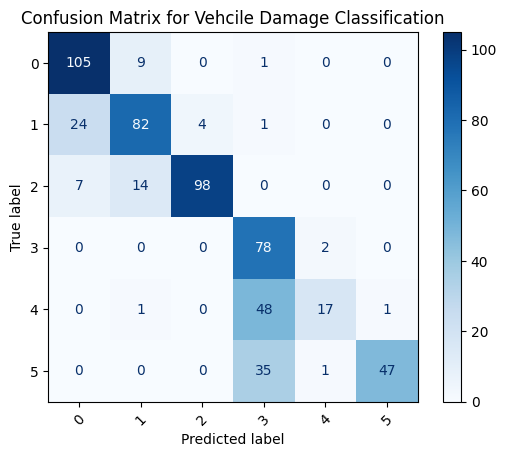

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix=confusion_matrix(labels,predictions,labels=np.arange(num_classes))
disp=ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=np.arange(num_classes))
disp.plot(cmap=plt.cm.Blues,xticks_rotation=45)
plt.title("Confusion Matrix for Vehcile Damage Classification")
plt.show()

In [62]:
torch.save(model.state_dict(),"saved_model.pth")